# Defining the train,test and model directories

In [1]:
import os
import pandas as pd
import pickle
import shutil
import numpy as np
import seaborn as sns
from sklearn.datasets import load_files
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D, Flatten, Dense, Dropout, Input
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from keras.models import Model
from keras.layers.merge import concatenate

from PIL import ImageFile   
from sklearn.model_selection import train_test_split
from keras.preprocessing import image                  
from tqdm import tqdm
# Defining the train,test and model directories
from keras.applications.resnet import ResNet50

# Defining the train,test and model directories

In [3]:
TEST_DIR = 'imgs/test'
TRAIN_DIR = 'imgs/train'
MODEL_PATH = 'model/ResNet50'
PICKLE_PATH = 'pickle'
CSV_DIR = 'csv_files'

In [4]:
if not os.path.exists(TEST_DIR):
    print("Testing data does not exists")
if not os.path.exists(TRAIN_DIR):
    print("Training data does not exists")
if not os.path.exists(MODEL_PATH):
    print("Model ResNet path does not exists")
    os.makedirs(MODEL_PATH)
    print("Model ResNet path created")
if not os.path.exists(PICKLE_PATH):
    os.makedirs(PICKLE_DIR)
if not os.path.exists(CSV_DIR):
    os.makedirs(CSV_DIR)

# Data Preparation

In [5]:
data_train = pd.read_csv('csv_files/train.csv')
data_test = pd.read_csv('csv_files/test.csv')

### Converting into numerical values

In [6]:
labels_list = list(set(data_train['ClassName'].values.tolist()))
labels_id = {label_name:id for id,label_name in enumerate(labels_list)}
print(labels_id)
data_train['ClassName'].replace(labels_id,inplace=True)

{'c8': 0, 'c7': 1, 'c9': 2, 'c4': 3, 'c3': 4, 'c1': 5, 'c2': 6, 'c6': 7, 'c5': 8, 'c0': 9}


In [7]:
with open('pickle/labels_list.pkl', "wb") as handle:
    pickle.dump(labels_id,handle)

In [8]:
labels = to_categorical(data_train['ClassName'])
print(labels.shape)# Splitting into Train and Test sets

(22424, 10)


# Splitting into Train and Test sets

In [9]:
from sklearn.model_selection import train_test_split

xtrain,xtest,ytrain,ytest = train_test_split(data_train.iloc[:,0],labels,test_size = 0.2,random_state=42)

### Converting into 64*64 images

In [10]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(64, 64))
    # convert PIL.Image.Image type to 3D tensor with shape (64, 64, 3)
    x = image.img_to_array(img)
   # convert 3D tensor to 4D tensor with shape (1, 64, 64, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [11]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(xtrain).astype('float32')/255 - 0.5
valid_tensors = paths_to_tensor(xtest).astype('float32')/255 - 0.5

100%|██████████████████████████████████████████████████████████████████████████████| 4485/4485 [01:44<00:00, 42.91it/s]


# ResNet50

In [12]:
model = ResNet50(include_top=False)
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [13]:
train_resnet50 = model.predict(train_tensors,verbose=1)
valid_resnet50 = model.predict(valid_tensors,verbose=1)

141/141 [==============================] - 18s 130ms/step


In [14]:
print("Train shape",train_resnet50.shape)
print("Validation shape",valid_resnet50.shape)

Train shape (17939, 2, 2, 2048)
Validation shape (4485, 2, 2, 2048)


In [15]:
train_features = train_resnet50[0]
valid_features = valid_resnet50[0]

In [16]:
print("Train features shape",train_features.shape)
print("Validation features shape",valid_features.shape)

Train features shape (2, 2, 2048)
Validation features shape (2, 2, 2048)


In [17]:
ResNet50_model = Sequential()
ResNet50_model.add(GlobalAveragePooling2D(input_shape=train_features.shape))
ResNet50_model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))

ResNet50_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 20,490
Trainable params: 20,490
Non-trainable params: 0
_________________________________________________________________


In [18]:
ResNet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [19]:
filepath = os.path.join(MODEL_PATH,"distracted-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',period=1)
callbacks_list = [checkpoint]

In [20]:
model_history = ResNet50_model.fit(train_resnet50,ytrain,validation_data = (valid_resnet50, ytest),epochs=400, batch_size=16, shuffle=True, callbacks=callbacks_list)

Epoch 1/400
1122/1122 [==============================] - 8s 1ms/step - loss: 2.2562 - accuracy: 0.1690 - val_loss: 2.1085 - val_accuracy: 0.2740

Epoch 00001: val_accuracy improved from -inf to 0.27402, saving model to model/ResNet50\distracted-01-0.27.hdf5
Epoch 2/400
1122/1122 [==============================] - 1s 881us/step - loss: 2.0880 - accuracy: 0.2862 - val_loss: 1.9971 - val_accuracy: 0.3485

Epoch 00002: val_accuracy improved from 0.27402 to 0.34849, saving model to model/ResNet50\distracted-02-0.35.hdf5
Epoch 3/400
1122/1122 [==============================] - 1s 872us/step - loss: 1.9798 - accuracy: 0.3404 - val_loss: 1.9474 - val_accuracy: 0.3229

Epoch 00003: val_accuracy did not improve from 0.34849
Epoch 4/400
1122/1122 [==============================] - 1s 887us/step - loss: 1.8984 - accuracy: 0.3846 - val_loss: 1.8586 - val_accuracy: 0.4047

Epoch 00004: val_accuracy improved from 0.34849 to 0.40468, saving model to model/ResNet50\distracted-04-0.40.hdf5
Epoch 5/400
1

1122/1122 [==============================] - 1s 951us/step - loss: 1.2221 - accuracy: 0.6213 - val_loss: 1.2289 - val_accuracy: 0.6225

Epoch 00034: val_accuracy improved from 0.61650 to 0.62252, saving model to model/ResNet50\distracted-34-0.62.hdf5
Epoch 35/400
1122/1122 [==============================] - 1s 1ms/step - loss: 1.2089 - accuracy: 0.6304 - val_loss: 1.2099 - val_accuracy: 0.6330

Epoch 00035: val_accuracy improved from 0.62252 to 0.63300, saving model to model/ResNet50\distracted-35-0.63.hdf5
Epoch 36/400
1122/1122 [==============================] - 1s 952us/step - loss: 1.2051 - accuracy: 0.6341 - val_loss: 1.2056 - val_accuracy: 0.6292

Epoch 00036: val_accuracy did not improve from 0.63300
Epoch 37/400
1122/1122 [==============================] - 1s 911us/step - loss: 1.1956 - accuracy: 0.6361 - val_loss: 1.2085 - val_accuracy: 0.6321

Epoch 00037: val_accuracy did not improve from 0.63300
Epoch 38/400
1122/1122 [==============================] - 1s 971us/step - loss:


Epoch 00069: val_accuracy did not improve from 0.68116
Epoch 70/400
1122/1122 [==============================] - 1s 855us/step - loss: 1.0447 - accuracy: 0.6783 - val_loss: 1.0475 - val_accuracy: 0.6758

Epoch 00070: val_accuracy did not improve from 0.68116
Epoch 71/400
1122/1122 [==============================] - 1s 840us/step - loss: 1.0272 - accuracy: 0.6857 - val_loss: 1.0413 - val_accuracy: 0.6876

Epoch 00071: val_accuracy improved from 0.68116 to 0.68763, saving model to model/ResNet50\distracted-71-0.69.hdf5
Epoch 72/400
1122/1122 [==============================] - 1s 865us/step - loss: 1.0256 - accuracy: 0.6868 - val_loss: 1.0368 - val_accuracy: 0.6783

Epoch 00072: val_accuracy did not improve from 0.68763
Epoch 73/400
1122/1122 [==============================] - 1s 845us/step - loss: 1.0257 - accuracy: 0.6891 - val_loss: 1.0519 - val_accuracy: 0.6680

Epoch 00073: val_accuracy did not improve from 0.68763
Epoch 74/400
1122/1122 [==============================] - 1s 835us/s

1122/1122 [==============================] - 1s 866us/step - loss: 0.9417 - accuracy: 0.7148 - val_loss: 0.9552 - val_accuracy: 0.7035

Epoch 00108: val_accuracy did not improve from 0.71126
Epoch 109/400
1122/1122 [==============================] - 1s 849us/step - loss: 0.9362 - accuracy: 0.7146 - val_loss: 0.9627 - val_accuracy: 0.7075

Epoch 00109: val_accuracy did not improve from 0.71126
Epoch 110/400
1122/1122 [==============================] - 1s 833us/step - loss: 0.9342 - accuracy: 0.7154 - val_loss: 0.9645 - val_accuracy: 0.6986

Epoch 00110: val_accuracy did not improve from 0.71126
Epoch 111/400
1122/1122 [==============================] - 1s 854us/step - loss: 0.9367 - accuracy: 0.7147 - val_loss: 0.9504 - val_accuracy: 0.7113

Epoch 00111: val_accuracy did not improve from 0.71126
Epoch 112/400
1122/1122 [==============================] - 1s 877us/step - loss: 0.9375 - accuracy: 0.7133 - val_loss: 0.9472 - val_accuracy: 0.7088

Epoch 00112: val_accuracy did not improve fr

1122/1122 [==============================] - 1s 868us/step - loss: 0.9002 - accuracy: 0.7260 - val_loss: 0.9147 - val_accuracy: 0.7142

Epoch 00146: val_accuracy did not improve from 0.72129
Epoch 147/400
1122/1122 [==============================] - 1s 859us/step - loss: 0.8983 - accuracy: 0.7268 - val_loss: 0.9081 - val_accuracy: 0.7208

Epoch 00147: val_accuracy did not improve from 0.72129
Epoch 148/400
1122/1122 [==============================] - 1s 867us/step - loss: 0.8724 - accuracy: 0.7356 - val_loss: 0.9116 - val_accuracy: 0.7191

Epoch 00148: val_accuracy did not improve from 0.72129
Epoch 149/400
1122/1122 [==============================] - 1s 862us/step - loss: 0.8867 - accuracy: 0.7321 - val_loss: 0.9039 - val_accuracy: 0.7229

Epoch 00149: val_accuracy improved from 0.72129 to 0.72285, saving model to model/ResNet50\distracted-149-0.72.hdf5
Epoch 150/400
1122/1122 [==============================] - 1s 850us/step - loss: 0.8673 - accuracy: 0.7381 - val_loss: 0.9147 - val_a

1122/1122 [==============================] - 1s 853us/step - loss: 0.8548 - accuracy: 0.7484 - val_loss: 0.9041 - val_accuracy: 0.7184

Epoch 00183: val_accuracy did not improve from 0.73066
Epoch 184/400
1122/1122 [==============================] - 1s 893us/step - loss: 0.8588 - accuracy: 0.7433 - val_loss: 0.8745 - val_accuracy: 0.73159 - accuracy: 

Epoch 00184: val_accuracy improved from 0.73066 to 0.73155, saving model to model/ResNet50\distracted-184-0.73.hdf5
Epoch 185/400
1122/1122 [==============================] - 1s 824us/step - loss: 0.8616 - accuracy: 0.7464 - val_loss: 0.8718 - val_accuracy: 0.7300

Epoch 00185: val_accuracy did not improve from 0.73155
Epoch 186/400
1122/1122 [==============================] - 1s 842us/step - loss: 0.8379 - accuracy: 0.7533 - val_loss: 0.8738 - val_accuracy: 0.7324

Epoch 00186: val_accuracy improved from 0.73155 to 0.73244, saving model to model/ResNet50\distracted-186-0.73.hdf5
Epoch 187/400
1122/1122 [==============================] -

1122/1122 [==============================] - 1s 896us/step - loss: 0.8160 - accuracy: 0.7562 - val_loss: 0.8569 - val_accuracy: 0.7362

Epoch 00221: val_accuracy did not improve from 0.73757
Epoch 222/400
1122/1122 [==============================] - 1s 886us/step - loss: 0.8211 - accuracy: 0.7514 - val_loss: 0.8624 - val_accuracy: 0.7331

Epoch 00222: val_accuracy did not improve from 0.73757
Epoch 223/400
1122/1122 [==============================] - 1s 931us/step - loss: 0.8180 - accuracy: 0.7566 - val_loss: 0.8581 - val_accuracy: 0.7367

Epoch 00223: val_accuracy did not improve from 0.73757
Epoch 224/400
1122/1122 [==============================] - 1s 887us/step - loss: 0.8291 - accuracy: 0.7491 - val_loss: 0.8550 - val_accuracy: 0.7378

Epoch 00224: val_accuracy improved from 0.73757 to 0.73779, saving model to model/ResNet50\distracted-224-0.74.hdf5
Epoch 225/400
1122/1122 [==============================] - 1s 910us/step - loss: 0.8277 - accuracy: 0.7505 - val_loss: 0.8617 - val_a

1122/1122 [==============================] - 1s 849us/step - loss: 0.8025 - accuracy: 0.7564 - val_loss: 0.8512 - val_accuracy: 0.7376

Epoch 00260: val_accuracy did not improve from 0.74470
Epoch 261/400
1122/1122 [==============================] - 1s 824us/step - loss: 0.8064 - accuracy: 0.7578 - val_loss: 0.8390 - val_accuracy: 0.7418

Epoch 00261: val_accuracy did not improve from 0.74470
Epoch 262/400
1122/1122 [==============================] - 1s 840us/step - loss: 0.7997 - accuracy: 0.7610 - val_loss: 0.8441 - val_accuracy: 0.7398

Epoch 00262: val_accuracy did not improve from 0.74470
Epoch 263/400
1122/1122 [==============================] - 1s 854us/step - loss: 0.8051 - accuracy: 0.7615 - val_loss: 0.8455 - val_accuracy: 0.7411

Epoch 00263: val_accuracy did not improve from 0.74470
Epoch 264/400
1122/1122 [==============================] - 1s 853us/step - loss: 0.8057 - accuracy: 0.7606 - val_loss: 0.8397 - val_accuracy: 0.7472

Epoch 00264: val_accuracy improved from 0.74

1122/1122 [==============================] - 1s 841us/step - loss: 0.7995 - accuracy: 0.7659 - val_loss: 0.8368 - val_accuracy: 0.7478

Epoch 00299: val_accuracy did not improve from 0.74805
Epoch 300/400
1122/1122 [==============================] - 1s 851us/step - loss: 0.7885 - accuracy: 0.7581 - val_loss: 0.8319 - val_accuracy: 0.7452

Epoch 00300: val_accuracy did not improve from 0.74805
Epoch 301/400
1122/1122 [==============================] - 1s 841us/step - loss: 0.7815 - accuracy: 0.7649 - val_loss: 0.8318 - val_accuracy: 0.7505

Epoch 00301: val_accuracy improved from 0.74805 to 0.75050, saving model to model/ResNet50\distracted-301-0.75.hdf5
Epoch 302/400
1122/1122 [==============================] - 1s 854us/step - loss: 0.7797 - accuracy: 0.7652 - val_loss: 0.8334 - val_accuracy: 0.7423

Epoch 00302: val_accuracy did not improve from 0.75050
Epoch 303/400
1122/1122 [==============================] - 1s 839us/step - loss: 0.7995 - accuracy: 0.7636 - val_loss: 0.8366 - val_a

1122/1122 [==============================] - 1s 852us/step - loss: 0.7786 - accuracy: 0.7674 - val_loss: 0.8209 - val_accuracy: 0.7485

Epoch 00338: val_accuracy did not improve from 0.75407
Epoch 339/400
1122/1122 [==============================] - 1s 832us/step - loss: 0.7764 - accuracy: 0.7664 - val_loss: 0.8152 - val_accuracy: 0.7525

Epoch 00339: val_accuracy did not improve from 0.75407
Epoch 340/400
1122/1122 [==============================] - 1s 844us/step - loss: 0.7809 - accuracy: 0.7711 - val_loss: 0.8268 - val_accuracy: 0.7467

Epoch 00340: val_accuracy did not improve from 0.75407
Epoch 341/400
1122/1122 [==============================] - 1s 843us/step - loss: 0.7669 - accuracy: 0.7737 - val_loss: 0.8310 - val_accuracy: 0.7409

Epoch 00341: val_accuracy did not improve from 0.75407
Epoch 342/400
1122/1122 [==============================] - 1s 861us/step - loss: 0.7730 - accuracy: 0.7728 - val_loss: 0.8157 - val_accuracy: 0.7505

Epoch 00342: val_accuracy did not improve fr

1122/1122 [==============================] - 1s 885us/step - loss: 0.7672 - accuracy: 0.7747 - val_loss: 0.8077 - val_accuracy: 0.7530

Epoch 00377: val_accuracy did not improve from 0.75630
Epoch 378/400
1122/1122 [==============================] - 1s 871us/step - loss: 0.7820 - accuracy: 0.7672 - val_loss: 0.8143 - val_accuracy: 0.7559

Epoch 00378: val_accuracy did not improve from 0.75630
Epoch 379/400
1122/1122 [==============================] - 1s 835us/step - loss: 0.7714 - accuracy: 0.7692 - val_loss: 0.8182 - val_accuracy: 0.7501

Epoch 00379: val_accuracy did not improve from 0.75630
Epoch 380/400
1122/1122 [==============================] - 1s 852us/step - loss: 0.7598 - accuracy: 0.7745 - val_loss: 0.8162 - val_accuracy: 0.7536

Epoch 00380: val_accuracy did not improve from 0.75630
Epoch 381/400
1122/1122 [==============================] - 1s 843us/step - loss: 0.7799 - accuracy: 0.7663 - val_loss: 0.8152 - val_accuracy: 0.7489

Epoch 00381: val_accuracy did not improve fr

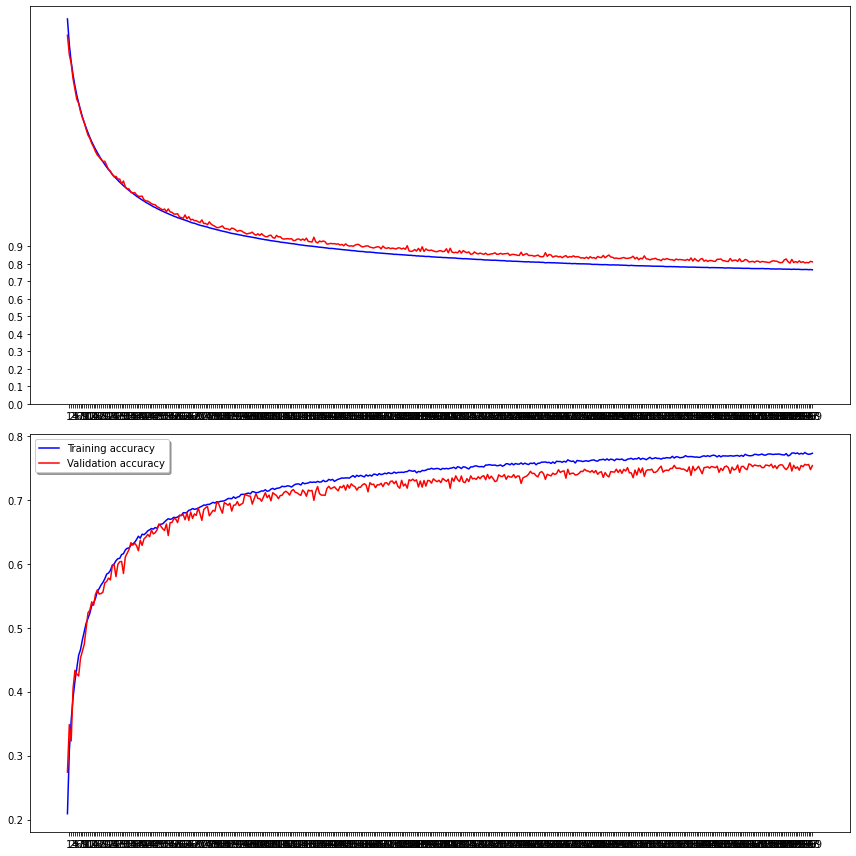

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(model_history.history['loss'], color='b', label="Training loss")
ax1.plot(model_history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 400, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(model_history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(model_history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 400, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [22]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(os.path.join(MODEL_PATH,"confusion_matrix.png"))
    return fig

In [23]:
def print_heatmap(n_labels, n_predictions, class_names):
    labels = n_labels #sess.run(tf.argmax(n_labels, 1))
    predictions = n_predictions #sess.run(tf.argmax(n_predictions, 1))

#     confusion_matrix = sess.run(tf.contrib.metrics.confusion_matrix(labels, predictions))
    matrix = confusion_matrix(labels.argmax(axis=1),predictions.argmax(axis=1))
    row_sum = np.sum(matrix, axis = 1)
    w, h = matrix.shape

    c_m = np.zeros((w, h))

    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]

    c = c_m.astype(dtype = np.uint8)

    
    heatmap = print_confusion_matrix(c, class_names, figsize=(18,10), fontsize=20)

In [24]:
class_names = list()
for name,idx in labels_id.items():
    class_names.append(name)
# print(class_names)
ypred = ResNet50_model.predict(valid_resnet50,verbose=1)

141/141 [==============================] - 0s 857us/step


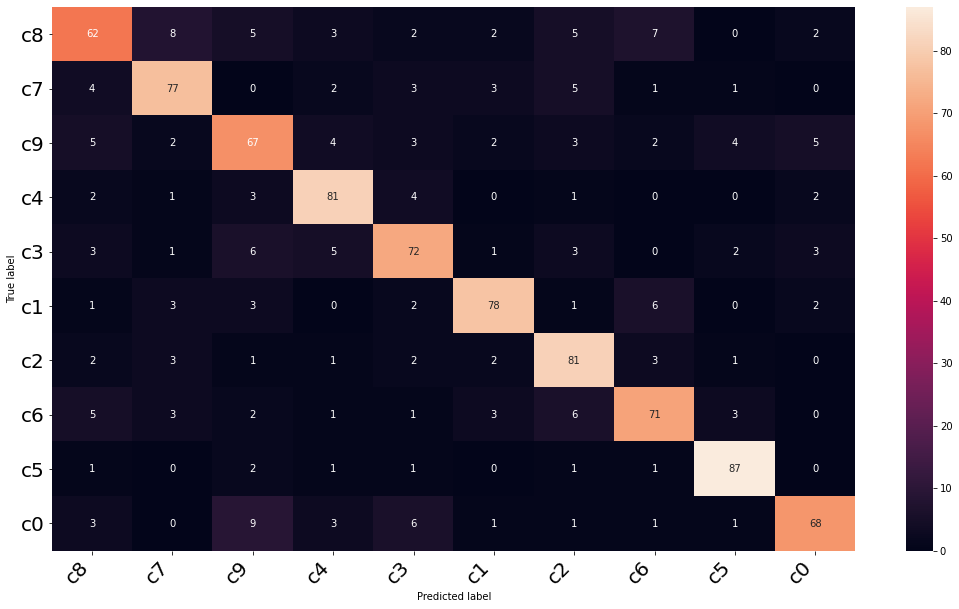

In [25]:
print_heatmap(ytest,ypred,class_names)

In [26]:
ypred_class = np.argmax(ypred,axis=1)
# print(ypred_class[:10])
ytest = np.argmax(ytest,axis=1)

In [27]:
accuracy = accuracy_score(ytest,ypred_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ytest, ypred_class,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ytest,ypred_class,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ytest,ypred_class,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.753623
Precision: 0.754948
Recall: 0.753623
F1 score: 0.753439
